In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
from datetime import datetime	
import random
import os
import PIL as pl
import re
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import pickle as pickle
from statistics import mean
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
path = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Data/Pickle_Data/'
p_models = '/Users/sepehrbe/DataSources/Kaggle/SkinCare/Models/Saved/'
G_path = '/Users/sepehrbe/Google_Drive/DataSources/SkinCare/Augmented_AutoEncoded/'
G_save = '/Users/sepehrbe/Google_Drive/DataSources/SkinCare/Saved/'

# **Import Meta Data**

In [10]:
f = 'HAM10000_metadata_augmented.csv'
meta_data_v0 = pd.read_csv(G_path + f)

In [3]:
meta_data_v0

,Unnamed: 0,index,lesion_id,image_id,dx,dx_type,age,sex,localization
0,0,0,HAM_0000118,ISIC_0027419,2.0,3.0,80.0,1.0,11.0
1,1,2,HAM_0002730,ISIC_0026769,2.0,3.0,80.0,1.0,11.0
2,2,4,HAM_0001466,ISIC_0031633,2.0,3.0,75.0,1.0,4.0
3,3,6,HAM_0002761,ISIC_0029176,2.0,3.0,60.0,1.0,5.0
4,4,8,HAM_0005132,ISIC_0025837,2.0,3.0,70.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...
8191,8191,10732,AUG_HAM_0005270,AUG_ISIC_0032270,6.0,3.0,70.0,0.0,9.0
8192,8192,10733,AUG_HAM_0006193,AUG_ISIC_0029877,6.0,1.0,80.0,1.0,9.0
8193,8193,10734,AUG_HAM_0003862,AUG_ISIC_0033031,6.0,3.0,45.0,1.0,14.0
8194,8194,10735,AUG_HAM_0006889,AUG_ISIC_0031197,6.0,3.0,20.0,1.0,14.0


In [4]:
batch_size = 16
training_set = torchvision.datasets.ImageFolder(root = G_path + "latent_dataset_train_valid_test20/Training_set", transform = transforms.ToTensor())
validation_set = torchvision.datasets.ImageFolder(root = G_path + "latent_dataset_train_valid_test20/Validation_set", transform = transforms.ToTensor())
test_set = torchvision.datasets.ImageFolder(root = G_path + "latent_dataset_train_valid_test20/Test_set", transform = transforms.ToTensor())

loader = DataLoader(dataset = training_set)

In [11]:
def import_imges(img_path):
    img_list = []
    for path, dirs, files in  os.walk(img_path):
        for f in files:
            img_list.append( path +'/' + f)
        for d in dirs:
            img_list.append( path + d)
    img_list = list(set([x for x in img_list if ".jpg" in x] ))

    dataset = pd.DataFrame(columns=['image_id','img_array'])
    for img in tqdm(img_list):
        img_name = re.findall('\w+', img)[-2:-1][0]
        image = pl.Image.open( img)
        img_array = np.asarray(image)
        new_row = pd.Series({'image_id':img_name,'img_array':img_array}, name='')
        dataset = dataset.append(new_row)
    return dataset

train_path = G_path + 'latent_dataset_train_valid_test20/Training_set'
valid_path = G_path + 'latent_dataset_train_valid_test20/Validation_set'
test_path = G_path + 'latent_dataset_train_valid_test20/Test_set'

trainin_set = import_imges(train_path)
valid_set = import_imges(valid_path)
test_set = import_imges(test_path)

100%|██████████| 820/820 [00:01<00:00, 698.03it/s]


In [37]:
trainin_set['type'] = 'train'
valid_set['type'] = 'valid'
test_set['type'] = 'test'
dataset_ = pd.concat([trainin_set,valid_set,test_set],axis=0)

data = dataset_.merge(meta_data_v0, how="left",on='image_id').rename(columns={'dx':'image_label'})

class_5 = data[data.image_label==5]
class_5_reduced = class_5.sample(n=2800, random_state=0)
data_blc = pd.concat([data[data.image_label!=5],class_5_reduced],axis=0)

In [38]:
df_ = data_blc
train_data = df_[df_.type=='train']
valid_data = df_[df_.type=='valid']
test_data = df_[df_.type=='test']
training_data = pd.concat([train_data,valid_data], axis=0)
print('Train size: ',train_data.shape[0] ,' Valid Size: ',valid_data.shape[0], ' Test size: ', test_data.shape[0])

Train size:  4483  Valid Size:  556  Test size:  554


In [39]:
training_arrays_scaled = np.stack(training_data['img_array'].values)  / 255
Mean = training_arrays_scaled.mean(axis = (0,1,2)) 
STD = training_arrays_scaled.std(axis = (0,1,2))
print(f"Mean : {Mean}   STD: {STD}") 

Mean : [0.40844554 0.15622149 0.23501862]   STD: [0.23811592 0.22666917 0.16962418]


In [40]:
#Train data standardization
train_arrays_std = np.stack(train_data['img_array'].values) / 255
for i in range(0,train_arrays_std.shape[0]):
    train_arrays_std[i] = (train_arrays_std[i] - Mean) / STD
#Validation data standardization
valid_arrays_std = np.stack(valid_data['img_array'].values) / 255
for i in range(0,valid_arrays_std.shape[0]):
    valid_arrays_std[i] = (valid_arrays_std[i] - Mean) / STD
#Test data standardization
test_arrays_std = np.stack(test_data['img_array'].values) / 255
for i in range(0,test_arrays_std.shape[0]):
    test_arrays_std[i] = (test_arrays_std[i] - Mean) / STD

In [41]:
Mean_t = train_arrays_std.mean(axis = (0,1,2)) 
STD_t = train_arrays_std.std(axis = (0,1,2))
print(f"Mean : {Mean_t}   STD: {STD_t}") 

Mean : [ 0.00251487 -0.00027692 -0.00313081]   STD: [1.00323344 1.00273593 0.99918996]


In [42]:
Mean_t = test_arrays_std.mean(axis = (0,1,2)) 
STD_t = test_arrays_std.std(axis = (0,1,2))
print(f"Mean : {Mean_t}   STD: {STD_t}") 

Mean : [ 0.00062381 -0.02893157 -0.00206642]   STD: [0.98936703 0.94563095 0.9829966 ]


In [43]:
train_arrays_std_T = torch.tensor(train_arrays_std, dtype= torch.float32).transpose(3,1)
train_labels = torch.tensor(train_data['image_label'].values.astype(np.long))

valid_arrays_std_T = torch.tensor(valid_arrays_std, dtype= torch.float32).transpose(3,1)
valid_labels = torch.tensor(valid_data['image_label'].values.astype(np.long))

test_arrays_std_T = torch.tensor(test_arrays_std, dtype= torch.float32).transpose(3,1)
test_labels = torch.tensor(test_data['image_label'].values.astype(np.long))

input_data = (train_arrays_std_T , valid_arrays_std_T, test_arrays_std_T )
labels = (train_labels,valid_labels,test_labels)

In [19]:
pickle.dump(input_data, open(G_path + 'AutoEncoder_input_data_blc', 'wb'))
pickle.dump(labels, open(G_path + 'AutoEncoder_labels_blc', 'wb'))

# **Filling NaN/Unkown Values**

In [7]:
meta_data = meta_data_v0.copy()
meta_data['age'].fillna(meta_data.groupby('sex')['age'].transform('mean'),inplace=True)
meta_data['sex'].replace('unknown',np.nan, inplace=True)
meta_data['sex'].fillna(meta_data.groupby('dx')['sex'].value_counts().index[0][1],inplace=True)

meta_data['localization'].replace('unknown',np.nan, inplace=True)
meta_data['localization'].fillna(meta_data.groupby(['dx','sex'])['localization'].value_counts().index[0][2],inplace=True)

In [8]:
for s in meta_data.columns:
    print('#########   ', s , '     #########################')
    print(meta_data[s].value_counts( dropna = False ))
    print('####################################################')

#########    lesion_id      #########################
HAM_0003789    6
HAM_0000835    6
HAM_0005263    6
HAM_0001863    6
HAM_0007427    5
              ..
HAM_0006000    1
HAM_0002762    1
HAM_0006894    1
HAM_0007132    1
HAM_0003347    1
Name: lesion_id, Length: 7470, dtype: int64
####################################################
#########    image_id      #########################
ISIC_0027419    1
ISIC_0030646    1
ISIC_0030164    1
ISIC_0032069    1
ISIC_0029007    1
               ..
ISIC_0028768    1
ISIC_0026383    1
ISIC_0025794    1
ISIC_0028888    1
ISIC_0032258    1
Name: image_id, Length: 10015, dtype: int64
####################################################
#########    dx      #########################
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64
####################################################
#########    dx_type      #########################
histo        5340
follow_up    3704
conse

# **Import Images**

In [9]:
img_list = os.listdir(img_path)
HAM_DataSource = pd.DataFrame(columns=['image_id','img_array'])
for img in img_list:
    img_name = img.replace('.jpg','')
    image = pl.Image.open( img_path + img)
    img_array = np.asarray(image)
    new_row = pd.Series({'image_id':img_name,'img_array':img_array}, name='')
    HAM_DataSource = HAM_DataSource.append(new_row)

In [10]:
HAM_DataSource = HAM_DataSource.merge(meta_data, how="left",on='image_id').rename(columns={'dx':'image_label'})
HAM_DataSource.image_label = pd.Categorical(HAM_DataSource.image_label)
HAM_DataSource['label_id'] = HAM_DataSource.image_label.cat.codes

# **Balance DataSet**

In [11]:
df_class1 = resample(HAM_DataSource[HAM_DataSource.label_id==5], replace=True,   n_samples=1200, random_state=0) 
df_other_classes = HAM_DataSource[HAM_DataSource.label_id!=5]
HAM_DataSource_blc = pd.concat([df_other_classes,df_class1], axis=0)

In [12]:
HAM_DataSource_blc.label_id.value_counts()

5    1200
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label_id, dtype: int64

# **Remove Duplications**

In [13]:
HAM_DataSource_blc_noDup = HAM_DataSource_blc.groupby('lesion_id').first().reset_index()

In [14]:
HAM_DataSource_blc_noDup.label_id.value_counts()

5    1039
2     727
4     614
1     327
0     228
6      98
3      73
Name: label_id, dtype: int64

In [15]:
HAM_DataSource_blc_noDup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106 entries, 0 to 3105
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lesion_id     3106 non-null   object  
 1   image_id      3106 non-null   object  
 2   img_array     3106 non-null   object  
 3   image_label   3106 non-null   category
 4   dx_type       3106 non-null   object  
 5   age           3106 non-null   float64 
 6   sex           3106 non-null   object  
 7   localization  3106 non-null   object  
 8   label_id      3106 non-null   int8    
dtypes: category(1), float64(1), int8(1), object(6)
memory usage: 176.4+ KB


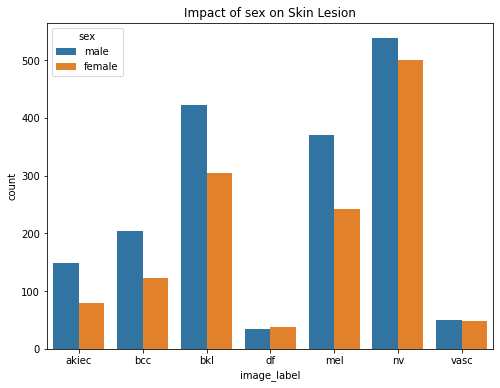

In [16]:
df_ = HAM_DataSource_blc_noDup
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='image_label', data=df_, hue='sex')
# ax.set_ylim(0,500)
plt.title("Impact of sex on Skin Lesion")
plt.show()

# **Functions**

In [17]:
def split_dataset(dataset, tst_ratio, valid_ratio):
    training_data, test_data = train_test_split(dataset, test_size = tst_ratio, random_state=0,stratify=dataset['label_id'])
    train_data, valid_data = train_test_split(training_data, test_size= valid_ratio, random_state=0,stratify=training_data['label_id'])
    train_data['type'] = 'train'
    valid_data['type'] = 'valid'
    test_data['type'] = 'test'
    dataset = pd.concat([train_data,valid_data,test_data],axis=0)
    return dataset

# **Split DataSet**

In [18]:
HAM_DataSource_blc = split_dataset(dataset = HAM_DataSource_blc , tst_ratio = 0.1, valid_ratio  = 0.1)
HAM_DataSource_blc_noDup = split_dataset(dataset = HAM_DataSource_blc_noDup , tst_ratio = 0.1, valid_ratio  = 0.1)

In [19]:
HAM_DataSource_blc[HAM_DataSource_blc.type=='train'].label_id.value_counts(normalize=True)

5    0.266083
4    0.246920
2    0.243635
1    0.114153
0    0.072269
6    0.031481
3    0.025459
Name: label_id, dtype: float64

In [20]:
HAM_DataSource_blc[HAM_DataSource_blc.type=='test'].label_id.value_counts(normalize=True)

5    0.266075
4    0.246120
2    0.243902
1    0.113082
0    0.073171
6    0.031042
3    0.026608
Name: label_id, dtype: float64

# **Standardization / Normalization**

In [21]:
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train|valid')][attr].mean()
    std = dataset[dataset.type.str.contains('train|valid')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset

In [22]:
def MinMaxScaling(dataset, attr):
    min = dataset[dataset.type.str.contains('train|valid')][attr].min()
    max = dataset[dataset.type.str.contains('train|valid')][attr].max()
    dataset[attr] = (dataset[attr] - min ) / (max-min)
    return dataset

In [23]:
# HAM_DataSource_blc_STD = standardizaion(HAM_DataSource_blc , 'age')
# HAM_DataSource_blc_noDup_STD = standardizaion(HAM_DataSource_blc_noDup , 'age')

# **Normalization**

In [24]:
HAM_DataSource_blc_STD = MinMaxScaling(HAM_DataSource_blc , 'age')
HAM_DataSource_blc_noDup_STD = MinMaxScaling(HAM_DataSource_blc_noDup , 'age')

In [25]:
HAM_DataSource_blc_STD['age']

1640    0.823529
6104    0.470588
8607    0.529412
9745    1.000000
2110    0.882353
          ...   
6008    0.647059
8295    0.529412
30      0.823529
8189    0.470588
2600    0.647059
Name: age, Length: 4510, dtype: float64

In [29]:
# pd.to_pickle(HAM_DataSource_blc_STD,G_path + 'DataSource_60x45_Red')
# pd.to_pickle(HAM_DataSource_blc_noDup_STD,G_path + 'DataSource_Red_noDup')

In [26]:
pickle.dump(HAM_DataSource_blc_STD, open(G_path + 'DataSource_60x45_Red', 'wb'))
pickle.dump(HAM_DataSource_blc_noDup_STD, open(G_path + 'DataSource_60x45_Red_noDup', 'wb'))

In [22]:
HAM_DataSource_blc_STD.type.value_counts()

train    3450
valid     609
test      451
Name: type, dtype: int64

In [41]:
pd.__version__

'1.4.2'

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL.Image import Transpose

df = pd.read_csv("HAM10000_metadata_processed.csv")
if 'Unnamed: 0' in df:
    df = df.drop(['Unnamed: 0'], axis=1)

sizes = dict()
labels = [5, 2, 4, 1, 0, 6, 3]
for l in range(len(list(df["dx"].value_counts()))):
    sizes[str(labels[l])] = list(df["dx"].value_counts())[l]
print(sizes)
cancer_indexes = [4, 1, 0] #equivalent directories: 2,3,6
tumor_indexes = [5, 2, 6, 3] #equivalent directories: 0,1,4,5

from PIL import Image

folder_dir = "dataset/"

for i in [3, 6, 5, 4]:
    f = folder_dir + str(i) + "/"
    for image in os.listdir(f):
        if "ISIC" in image and image.replace(".jpg", "") in list(df["image_id"]):
            print("Augmented image: ", image)
            im1 = Image.open(f + image)
            augmented = im1.transpose(Transpose.FLIP_LEFT_RIGHT)
            augmented = augmented.transpose(Transpose.FLIP_TOP_BOTTOM)
            augmented.save("dataset_augmented/" + str(i) + "/AUG_" + image)
            im1.save("dataset_augmented/" + str(i) + "/" + image)

            values = list(df.loc[df['image_id'] == image.replace(".jpg", "")].values)[0]
            values[0] = df["index"].max() + 1
            values[1] = "AUG_" + values[1]
            values[2] = "AUG_" + values[2]

            df_length = len(df)
            df.loc[df_length] = values

for i in [0, 2, 1]:
    f = folder_dir + str(i) + "/"
    for image in os.listdir(f):
        if "ISIC" in image and image.replace(".jpg", "") in list(df["image_id"]):
            #print(image)
            im1 = Image.open(f + image)
            im1 = im1.save("dataset_augmented/" + str(i) + "/" + image)


df.to_csv("HAM10000_metadata_augmented.csv")